In [1]:

import torch
import torch.nn as nn
import torch.optim as optim
import torchtext
from torchtext.vocab import build_vocab_from_iterator
import pickle
from pmf import PMF
from lr import LogReg
import numpy as np
from functools import reduce
from sklearn.decomposition import PCA

from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn.metrics import brier_score_loss
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
import numpy as np
import torch
import matplotlib.pylab as plt
import seaborn as sns

import pandas as pd

/Users/zekeweng/.pyenv/versions/3.9.10/lib/python3.9/site-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/Users/zekeweng/.pyenv/versions/3.9.10/lib/python3.9/site-packages/torchtext/utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)


In [2]:
SEED = 42
REPLACEMENT_LEVELS = [25, 50, 100, 250, 500, 1000]
LATENT_FACTORS = [1, 2, 3, 4, 5, 6]

df = pd.read_csv('data/men_data.csv')

In [5]:
def get_athlete_accuracy(df, model, names):
    accuracies = []
    for name in reversed(names):
        if name != 'other':
            df_climber = df.loc[df.Name == name]
        else:
            mask = df.Name.isin([climber for climber in model.climber_vocab.get_itos() if climber != 'other'])
            df_climber= df.loc[~mask]

        y_true = df_climber['Status'].values
        y_pred = model.predict(df_climber)
        y_pred_binary = np.round(y_pred)
        accuracies.append(accuracy_score(y_true, y_pred_binary))
    return accuracies

def get_athlete_counts(df, model, names):
    accuracies = []
    for name in names:
        if name != 'other':
            df_climber = df.loc[df.Name == name]
        else:
            mask = df.Name.isin([climber for climber in model.climber_vocab.get_itos() if climber != 'other'])
            df_climber= df.loc[~mask]
        accuracies.append(df_climber.shape[0])
    return accuracies

In [120]:
def create_correlation_matrices():
    athletes = {}

    for replacement_level in REPLACEMENT_LEVELS:
        with open(f"models/lr/model_rl_{replacement_level}_fold_0.pkl", 'rb') as f:            ########## CHANGE PATH FOR COMPLETE MODEL
            lr_model = pickle.load(f)

        fig, axs = plt.subplots(nrows=1, ncols=len(LATENT_FACTORS), figsize=(28, 8))

        for num_factors in LATENT_FACTORS:
            # lr_weights = dict(zip(lr_model.climber_vocab.get_itos(), [lr_model.lr.intercept_[0]] + lr_model.lr.coef_.flatten().tolist())) ### WITH OTHER
            lr_climbers = lr_model.climber_vocab.get_itos()[1:]
            lr_athletes = pd.DataFrame({
                "coefs": lr_model.lr.coef_.flatten().tolist(),
            }, index=lr_climbers)

            pmf_model = torch.load(f"models/pmf/model_rl_{replacement_level}_d_{num_factors}_fold_1.pth")  ########## CHANGE PATH FOR COMPLETE MODEL
            pmf_model.eval()


            pmf_climbers = pmf_model.climber_vocab.get_itos()[1:]                                         ########## WITHOUT OTHER ATM
            pmf_athletes = pd.DataFrame({
                "weights": pmf_model.climber_embedding.weight.data.numpy().tolist()[1:],
                "pmf_accuracy": get_athlete_accuracy(df, pmf_model, pmf_climbers),
                "size": get_athlete_counts(df, pmf_model, pmf_climbers),
            }, index=pmf_climbers)

            weights = pmf_athletes['weights'].apply(pd.Series)
            pmf_athletes = pd.concat([pmf_athletes[['pmf_accuracy','size']], weights], axis=1)
            pmf_athletes.columns = ['pmf_accuracy', 'size'] + [f'weight_{i+1}' for i in range(weights.shape[1])]

            ### Correlations
            lr_pmf_athletes = pd.merge(lr_athletes, pmf_athletes, left_index=True, right_index=True, how='outer')
            lr_pmf_athletes.dropna(inplace=True)
            rows = [row for row in lr_pmf_athletes.columns if row.startswith('w')]
            cols = ['coefs','pmf_accuracy','size']
            df_corr = lr_pmf_athletes.corr().loc[rows, cols]
            sns.heatmap(df_corr, annot=True, cmap='coolwarm', center=0, vmin=-1, vmax=1, ax=axs[num_factors-1])

            ### PCA
            embeddings = lr_pmf_athletes[rows].values
            components = min(embeddings.shape[0], embeddings.shape[1])
            pca = PCA(n_components=components)
            pcs = pca.fit_transform(embeddings)

            for pc in range(components):
                lr_pmf_athletes[f'PC{pc+1}'] = pcs[:, pc]

            athletes[f'{replacement_level}_{num_factors}'] = lr_pmf_athletes

        plt.suptitle(f'Correlation Matrices at RL: {replacement_level}', fontsize=16)

        plt.tight_layout()
        plt.savefig(f'figs/correlations_{replacement_level}')
        plt.close(fig)

    return athletes

/Users/zekeweng/.pyenv/versions/3.9.10/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.5.1 when using version 1.5.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/zekeweng/.pyenv/versions/3.9.10/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.5.1 when using version 1.5.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/zekeweng/.pyenv/versions/3.9.10/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator Logisti

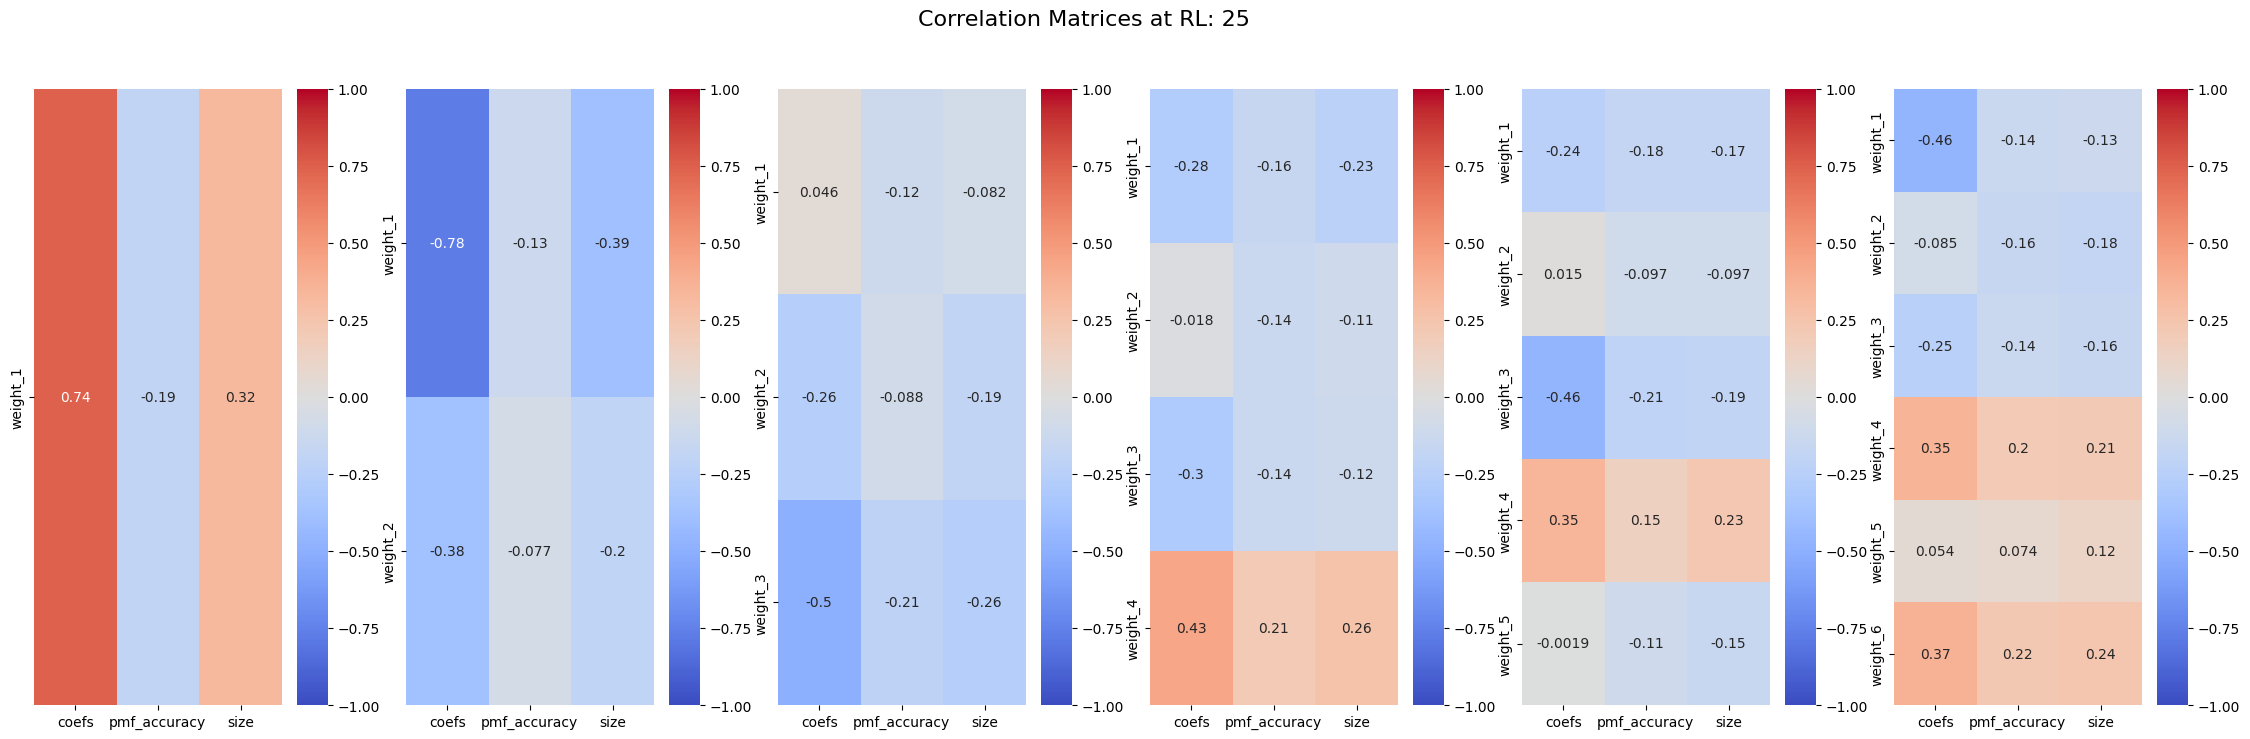

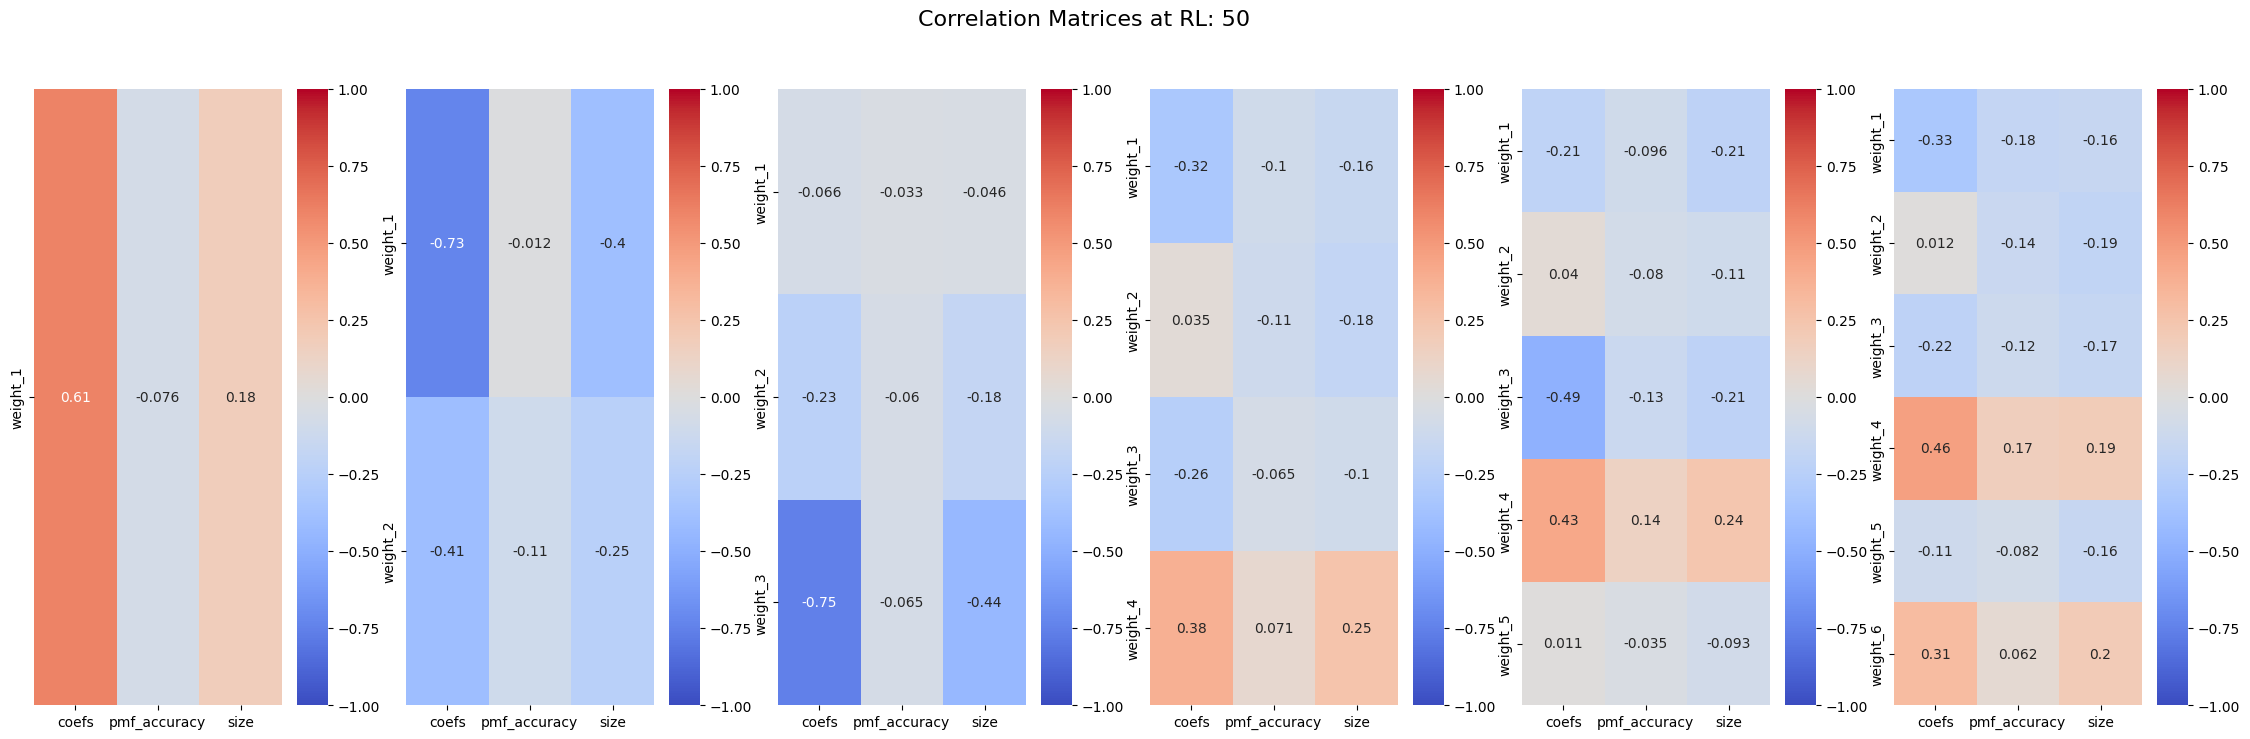

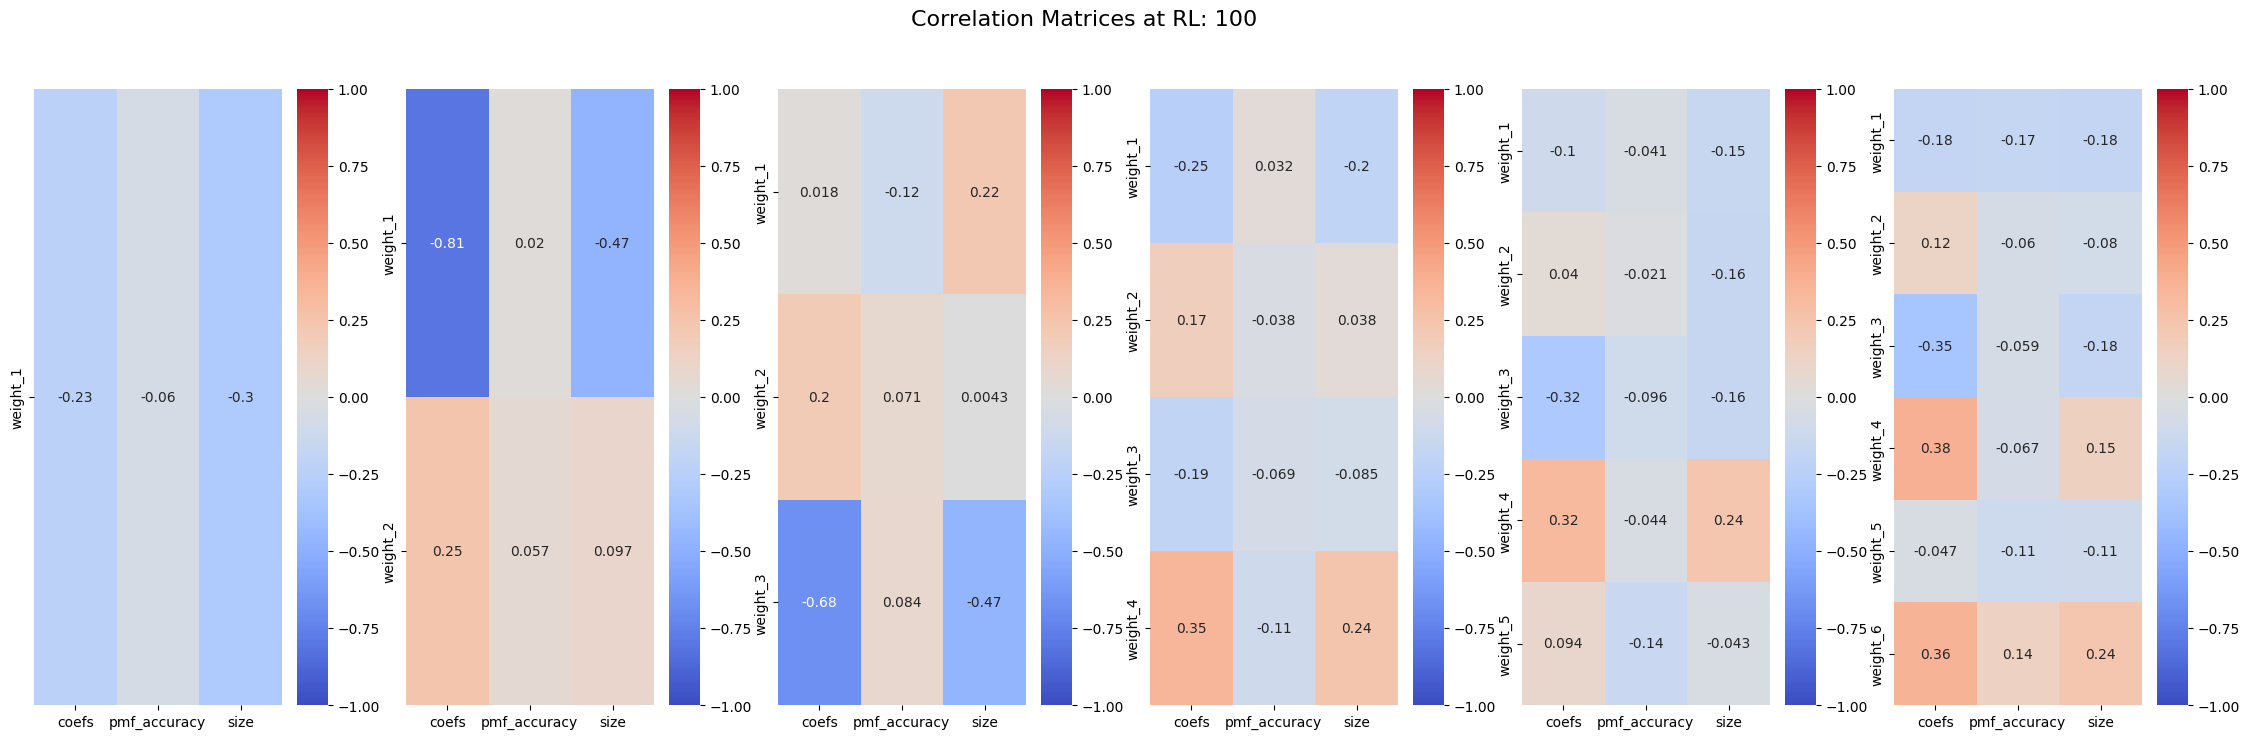

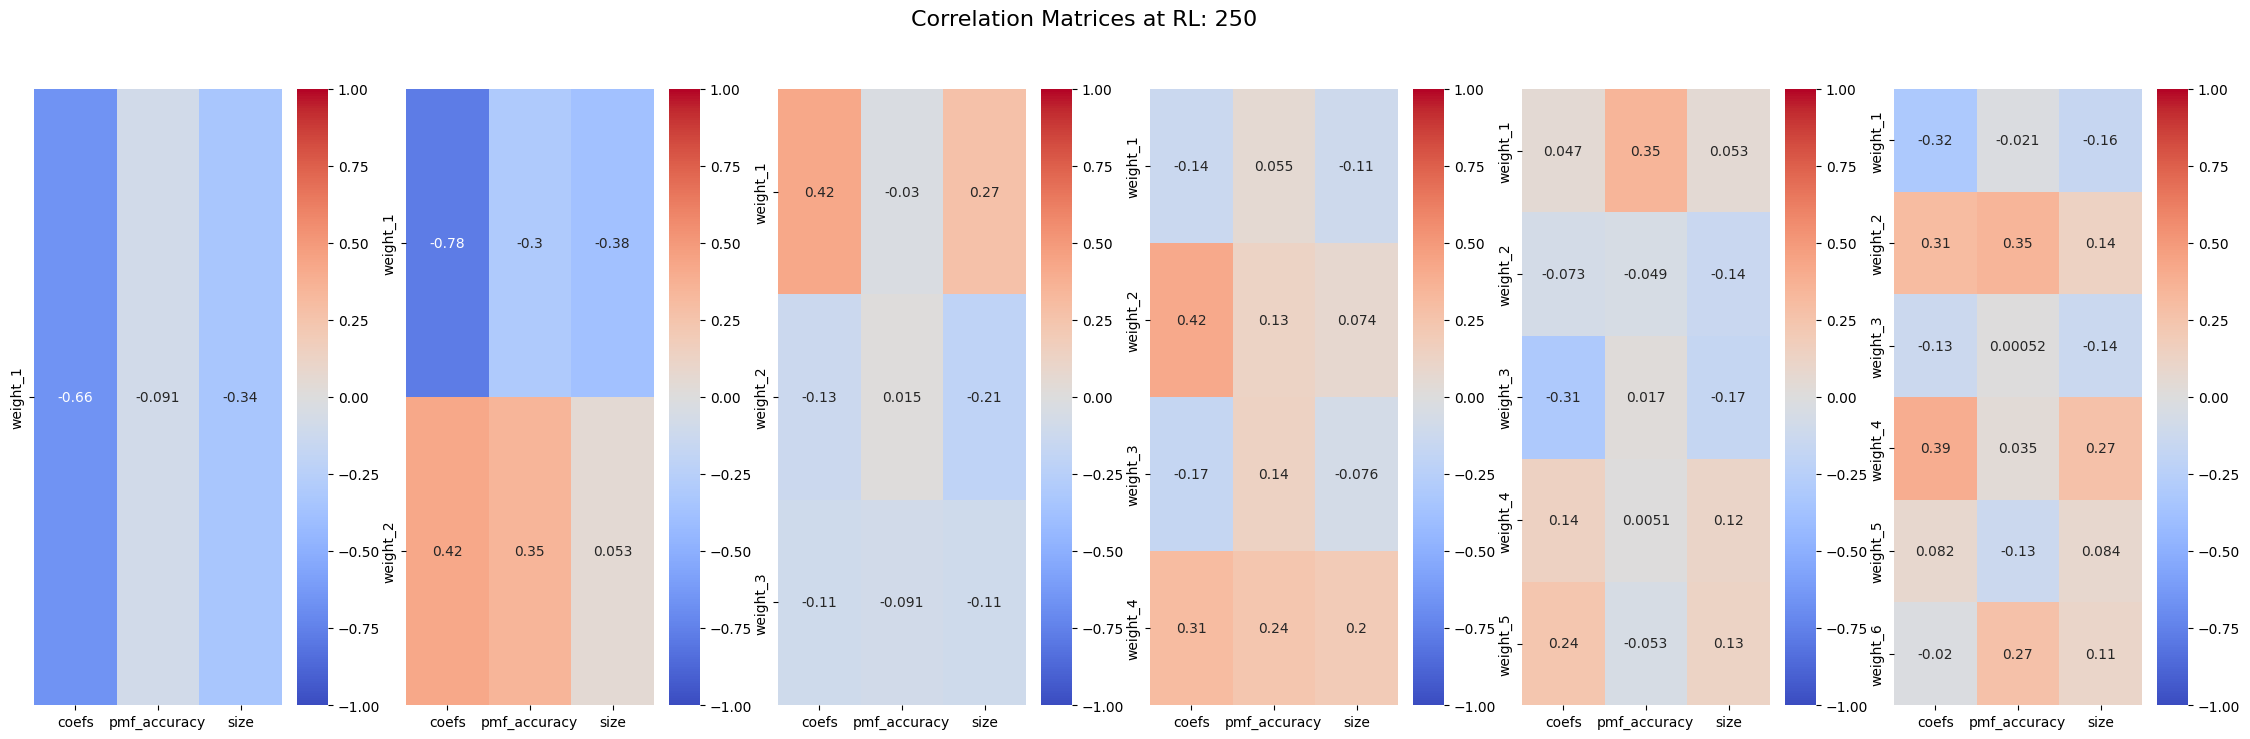

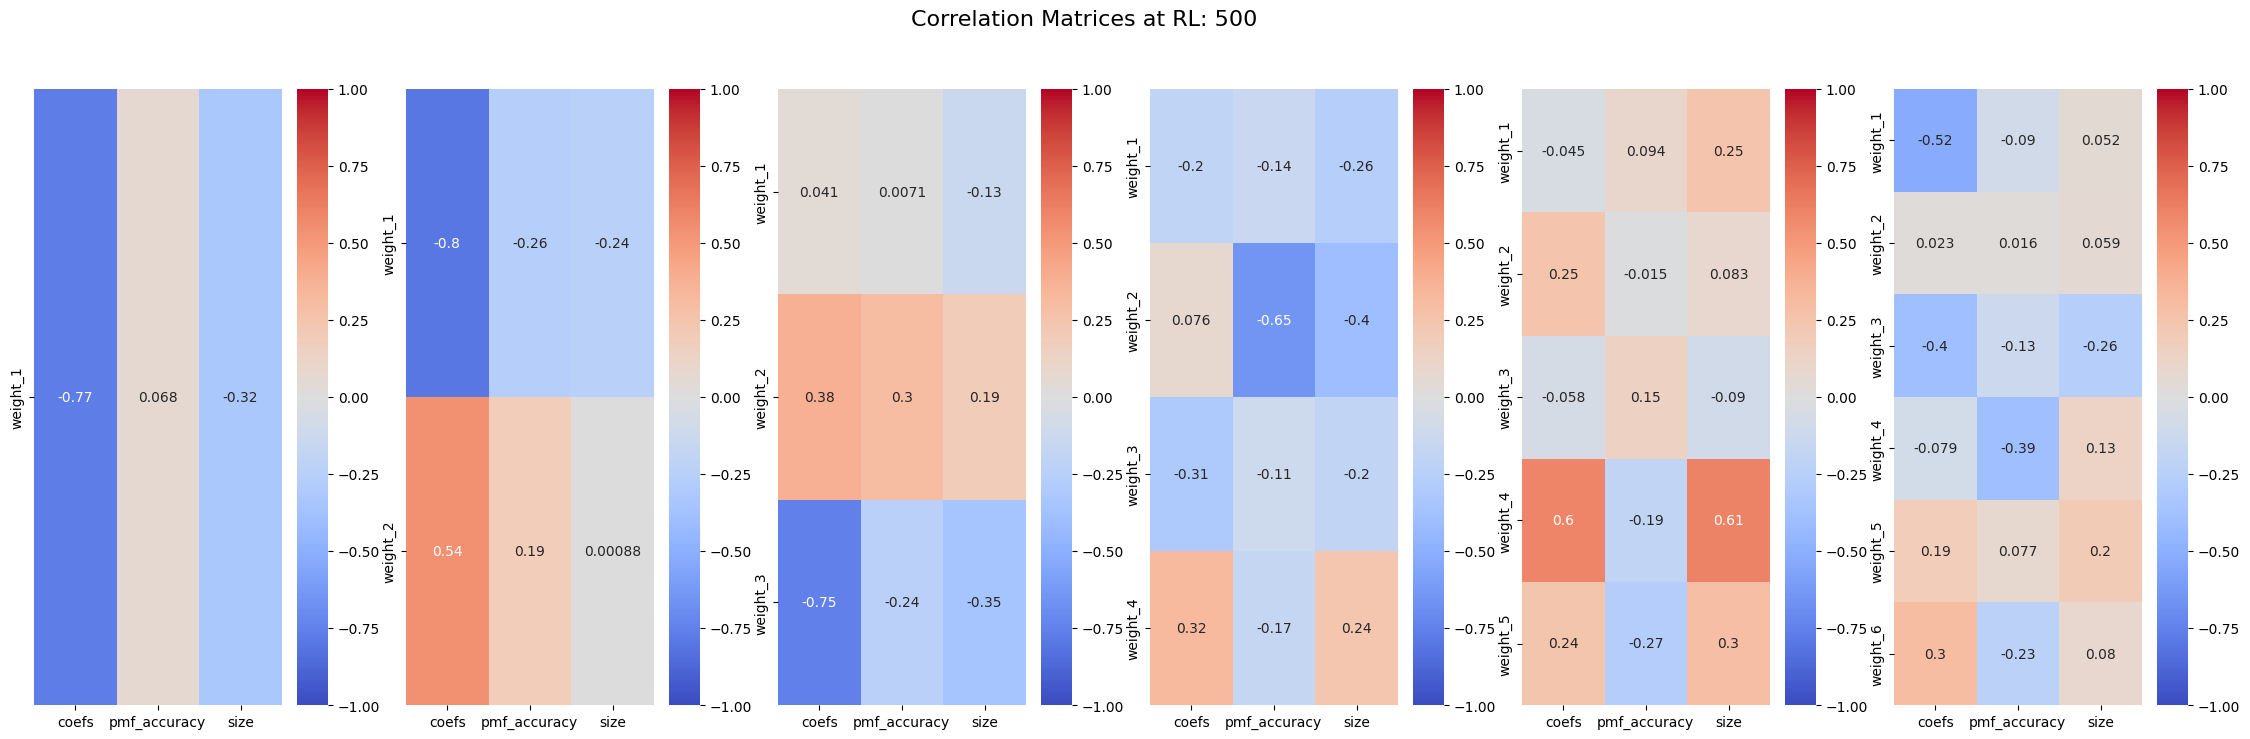

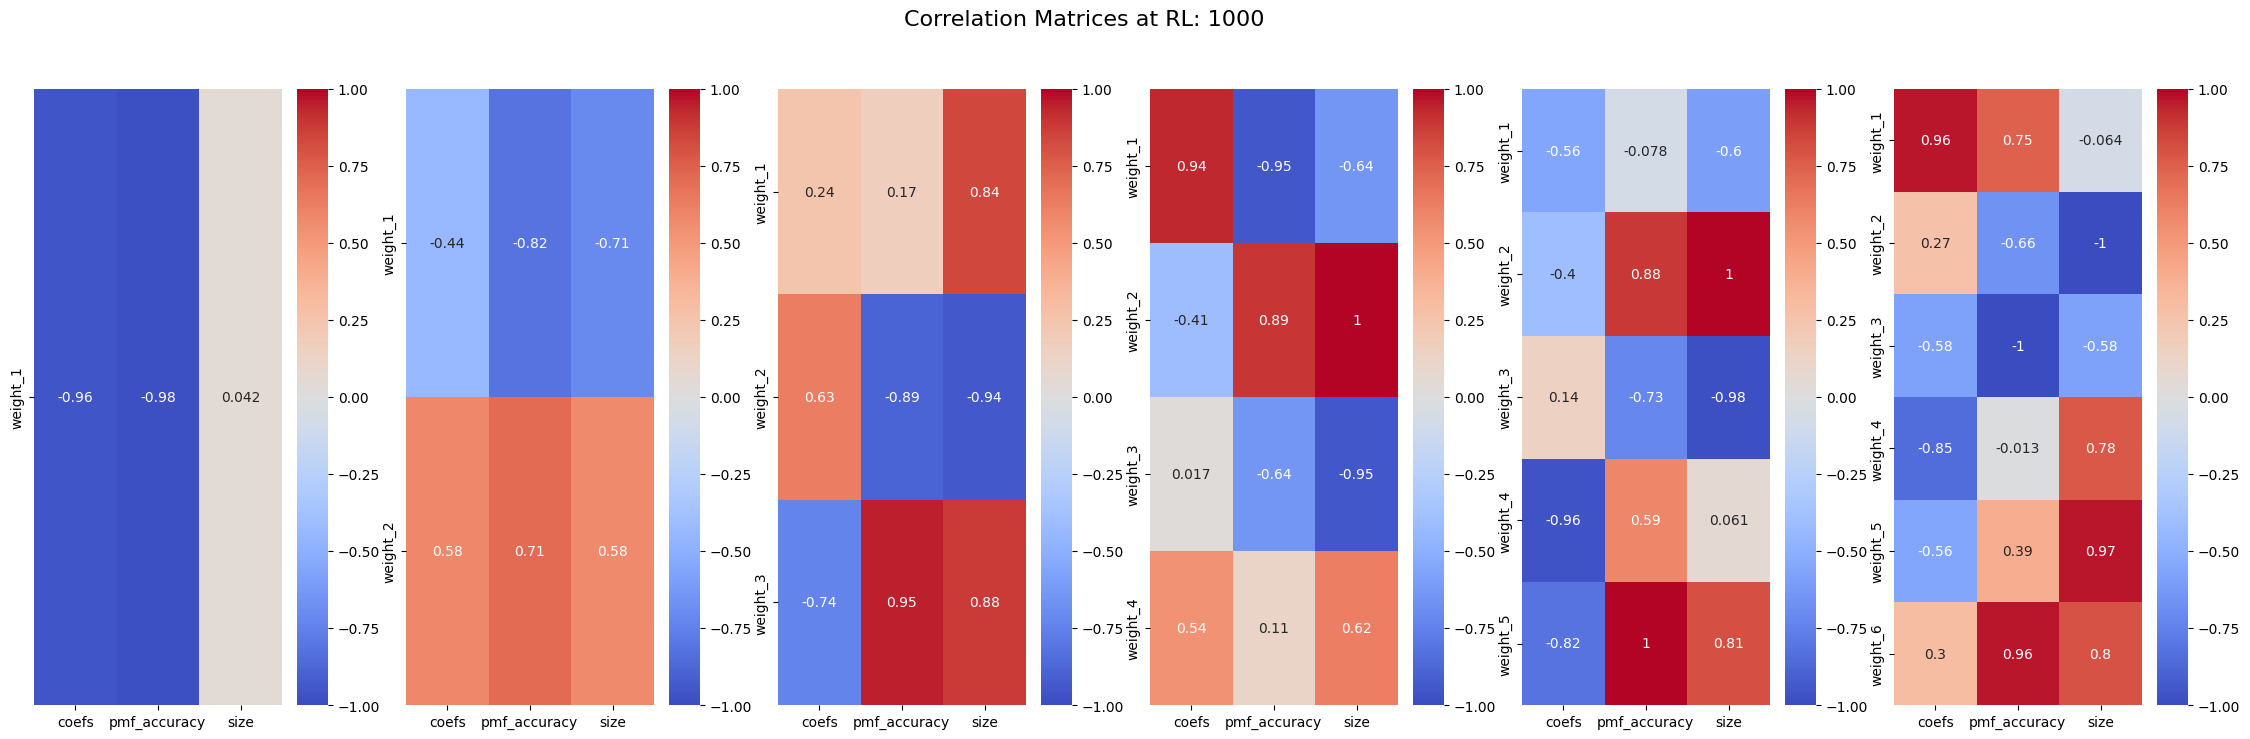

In [121]:
athletes = create_correlation_matrices()

### These PCs ahve excluded 'Other' will continue tomorrow - Height and Weights is last part for this 

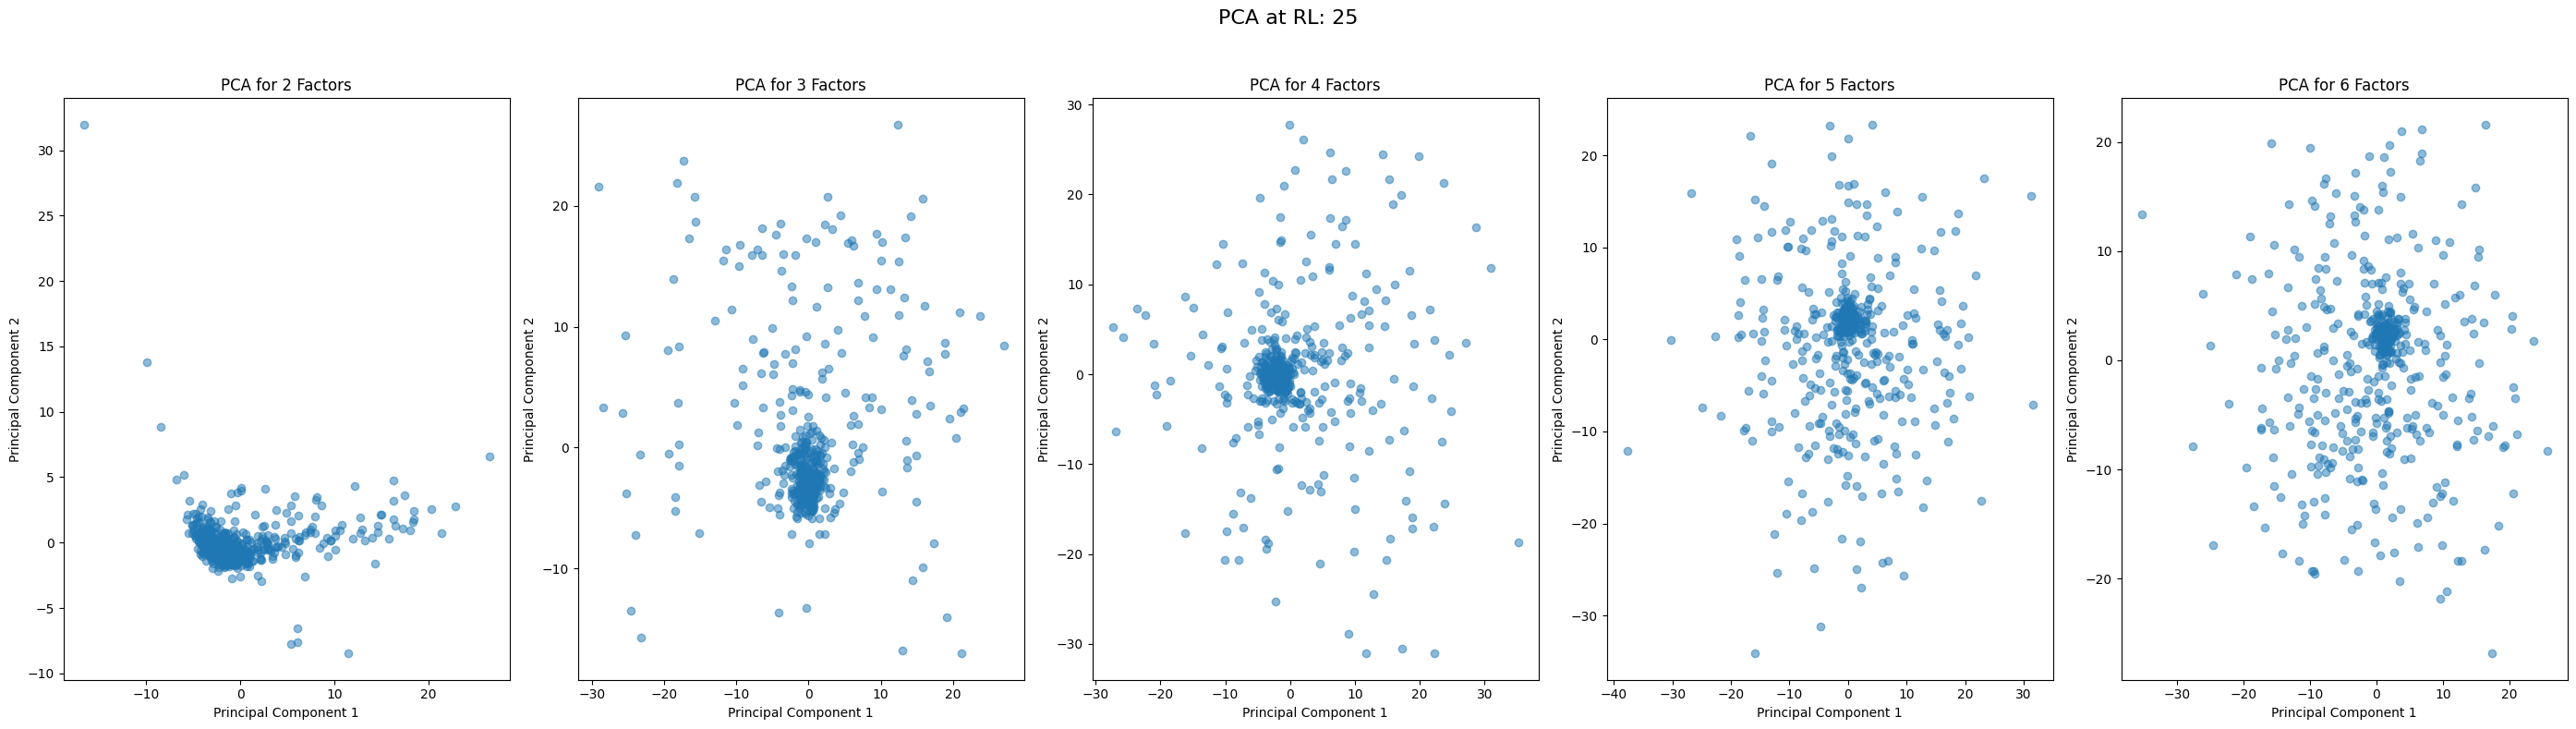

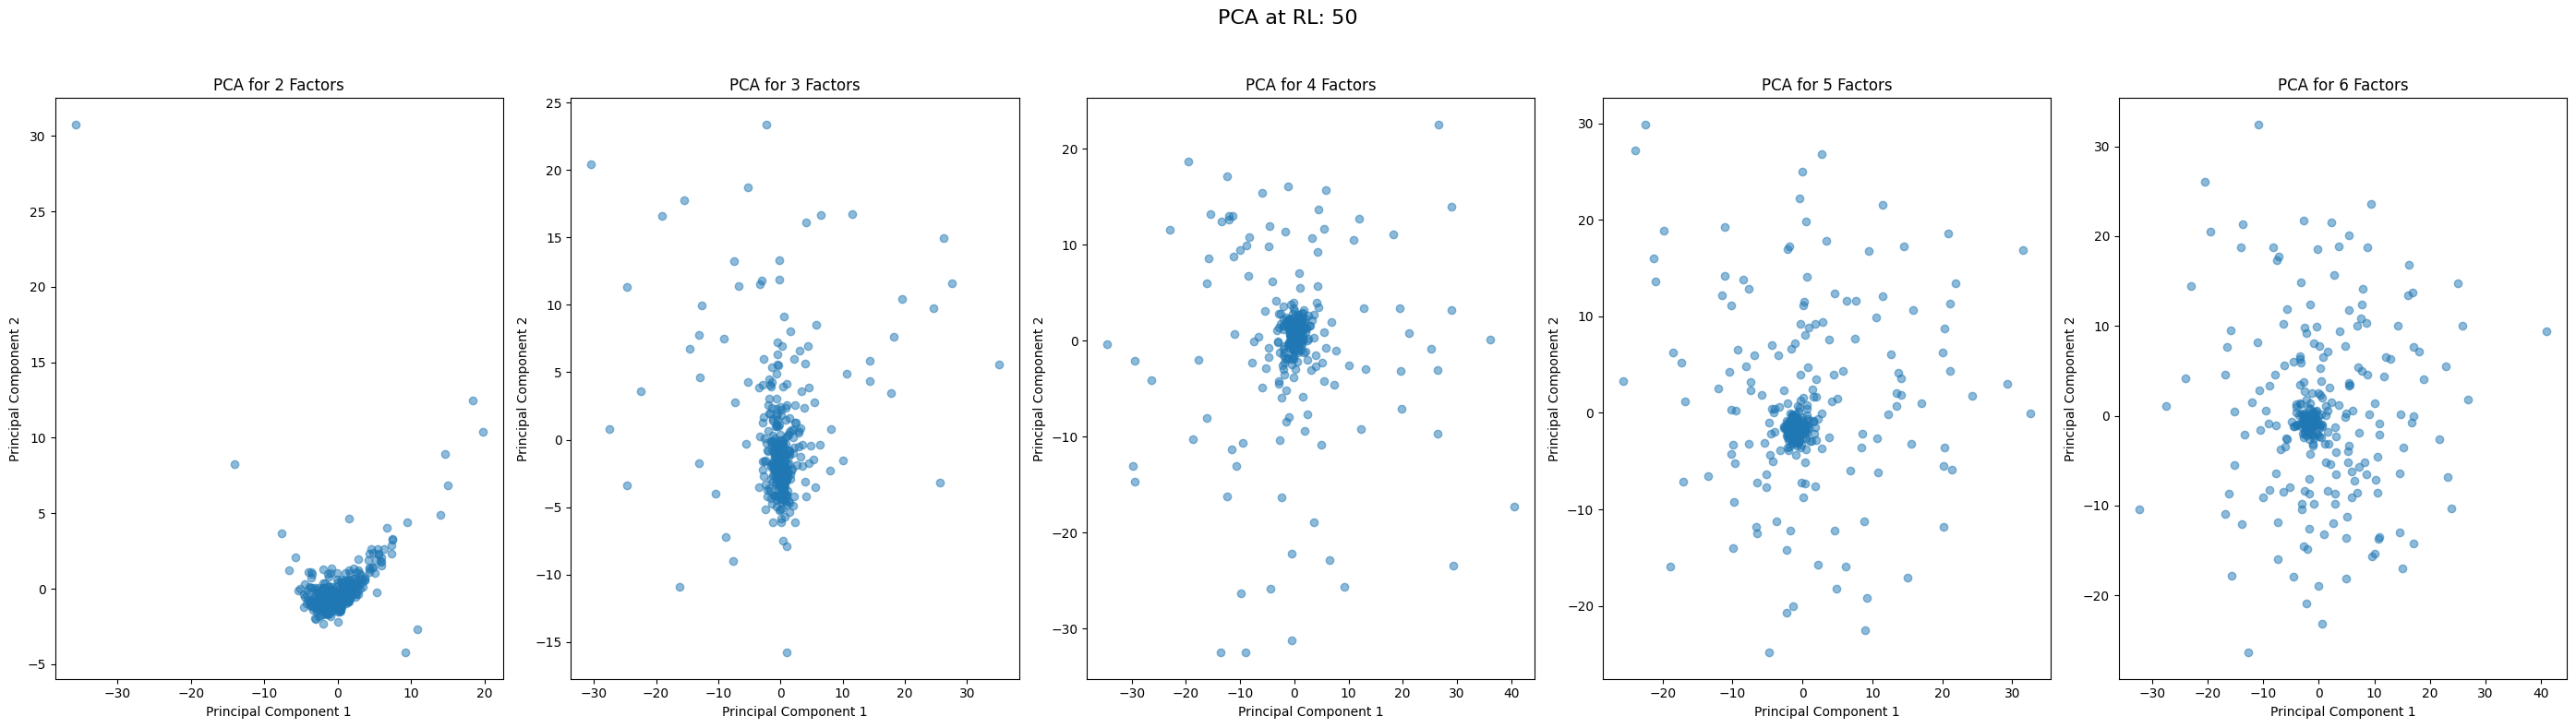

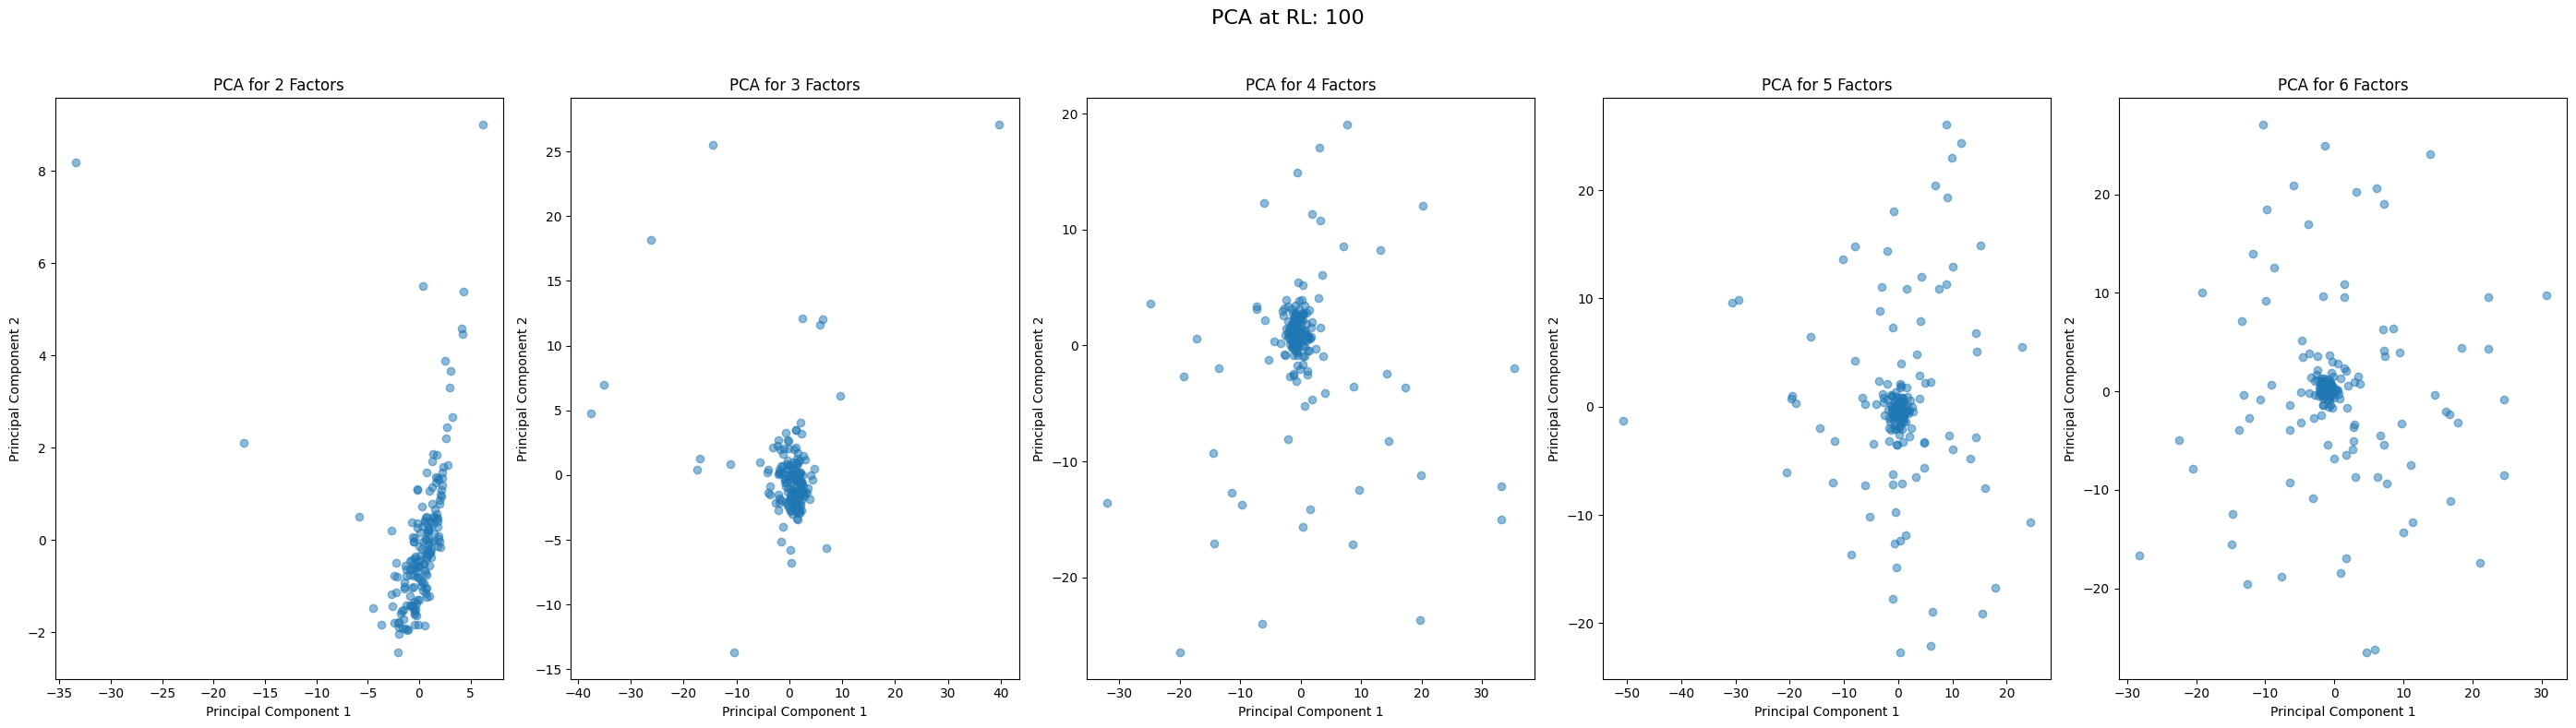

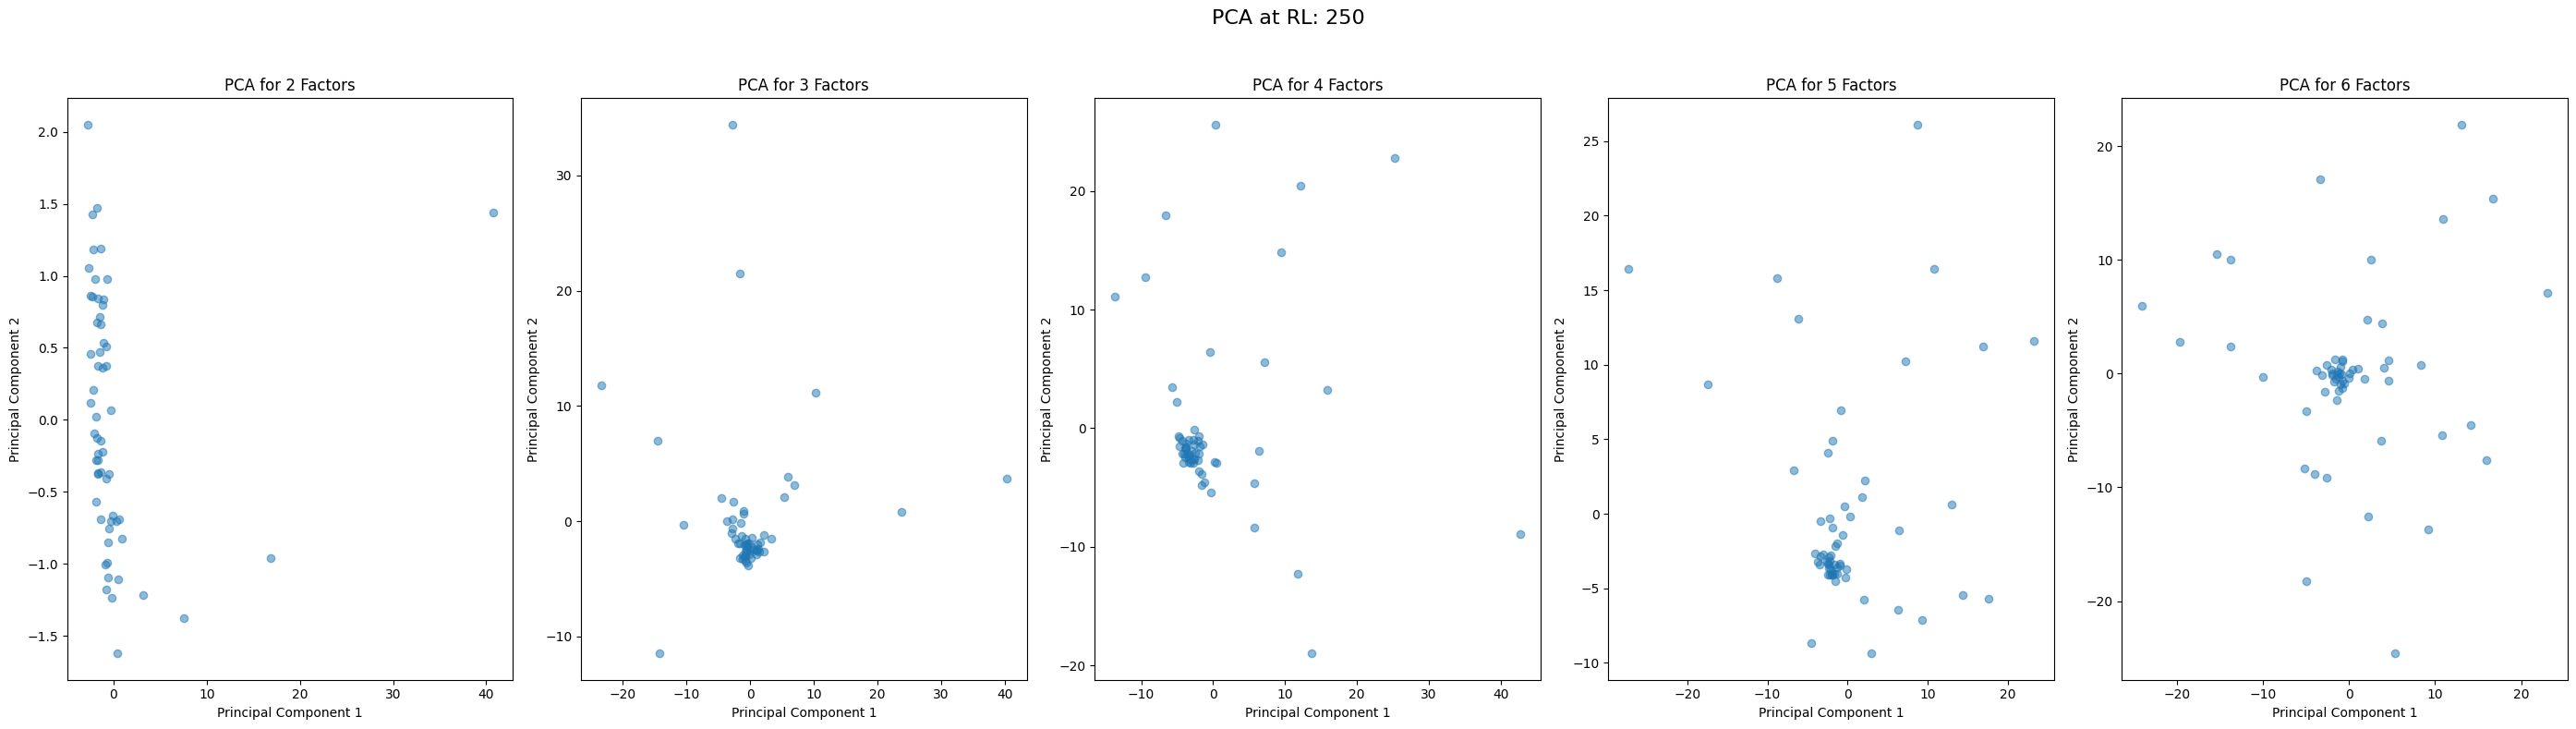

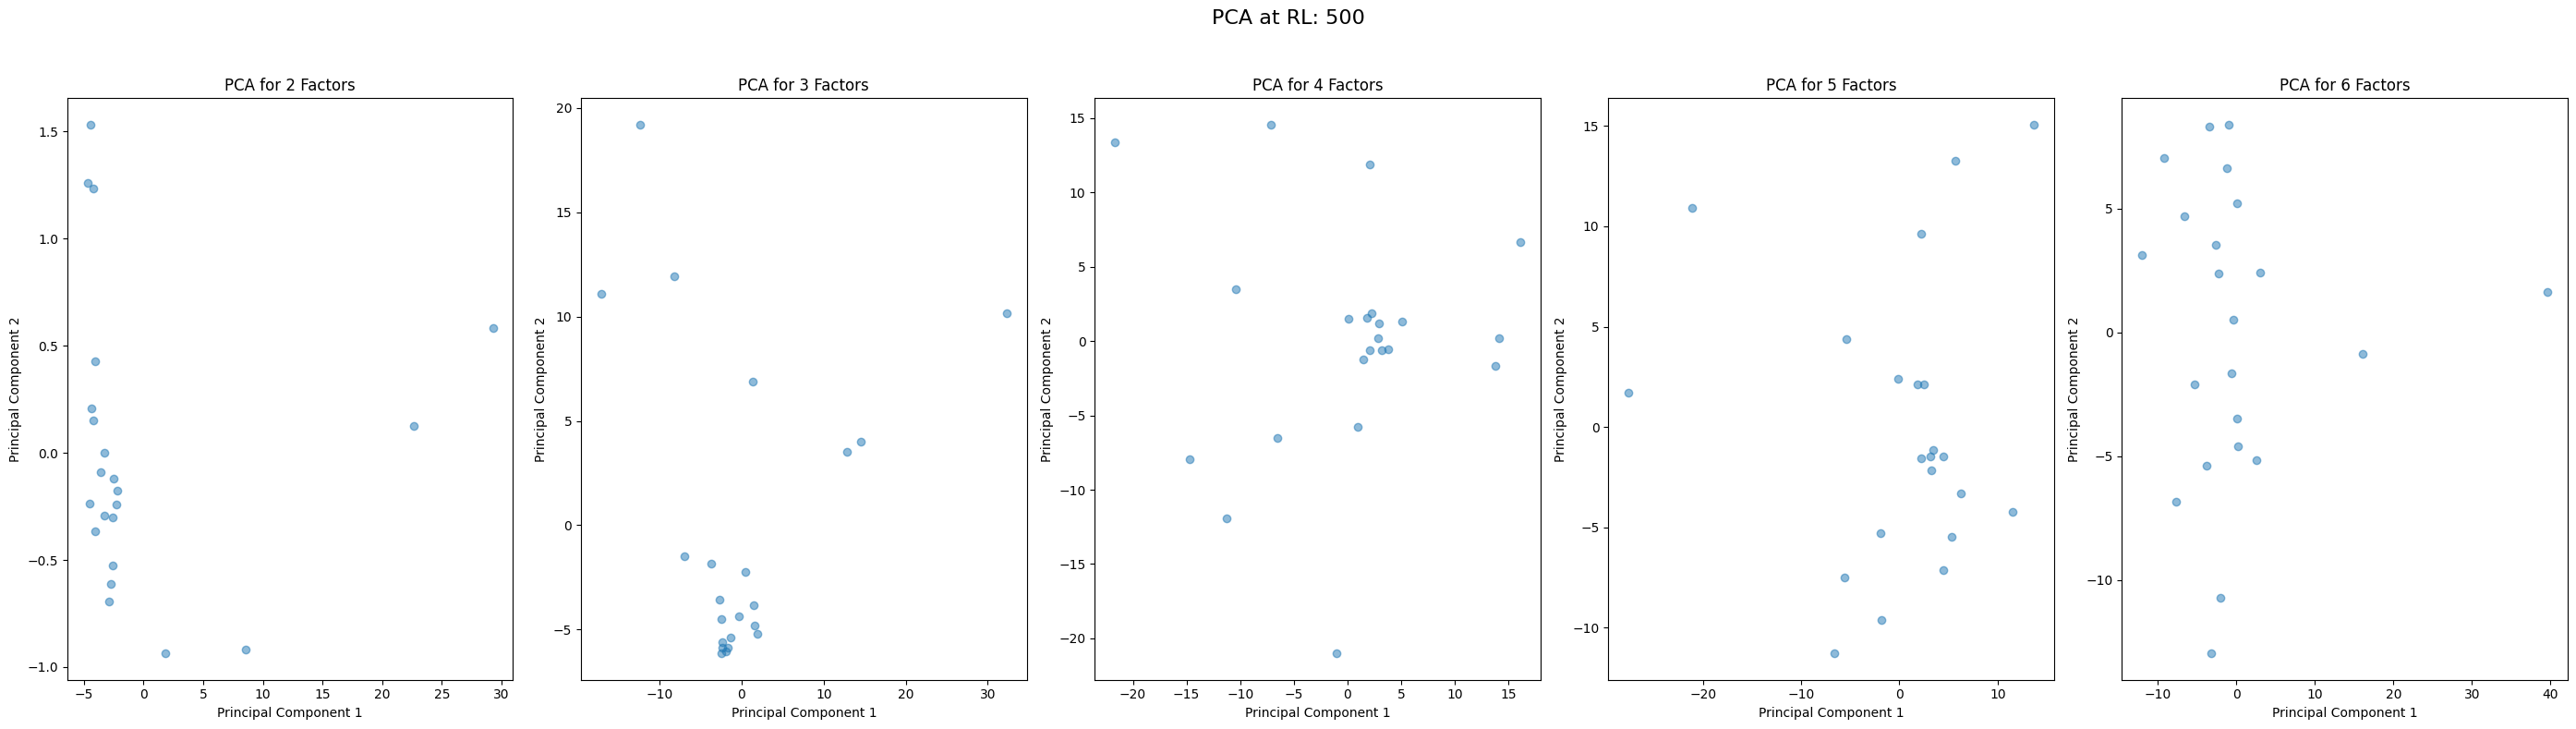

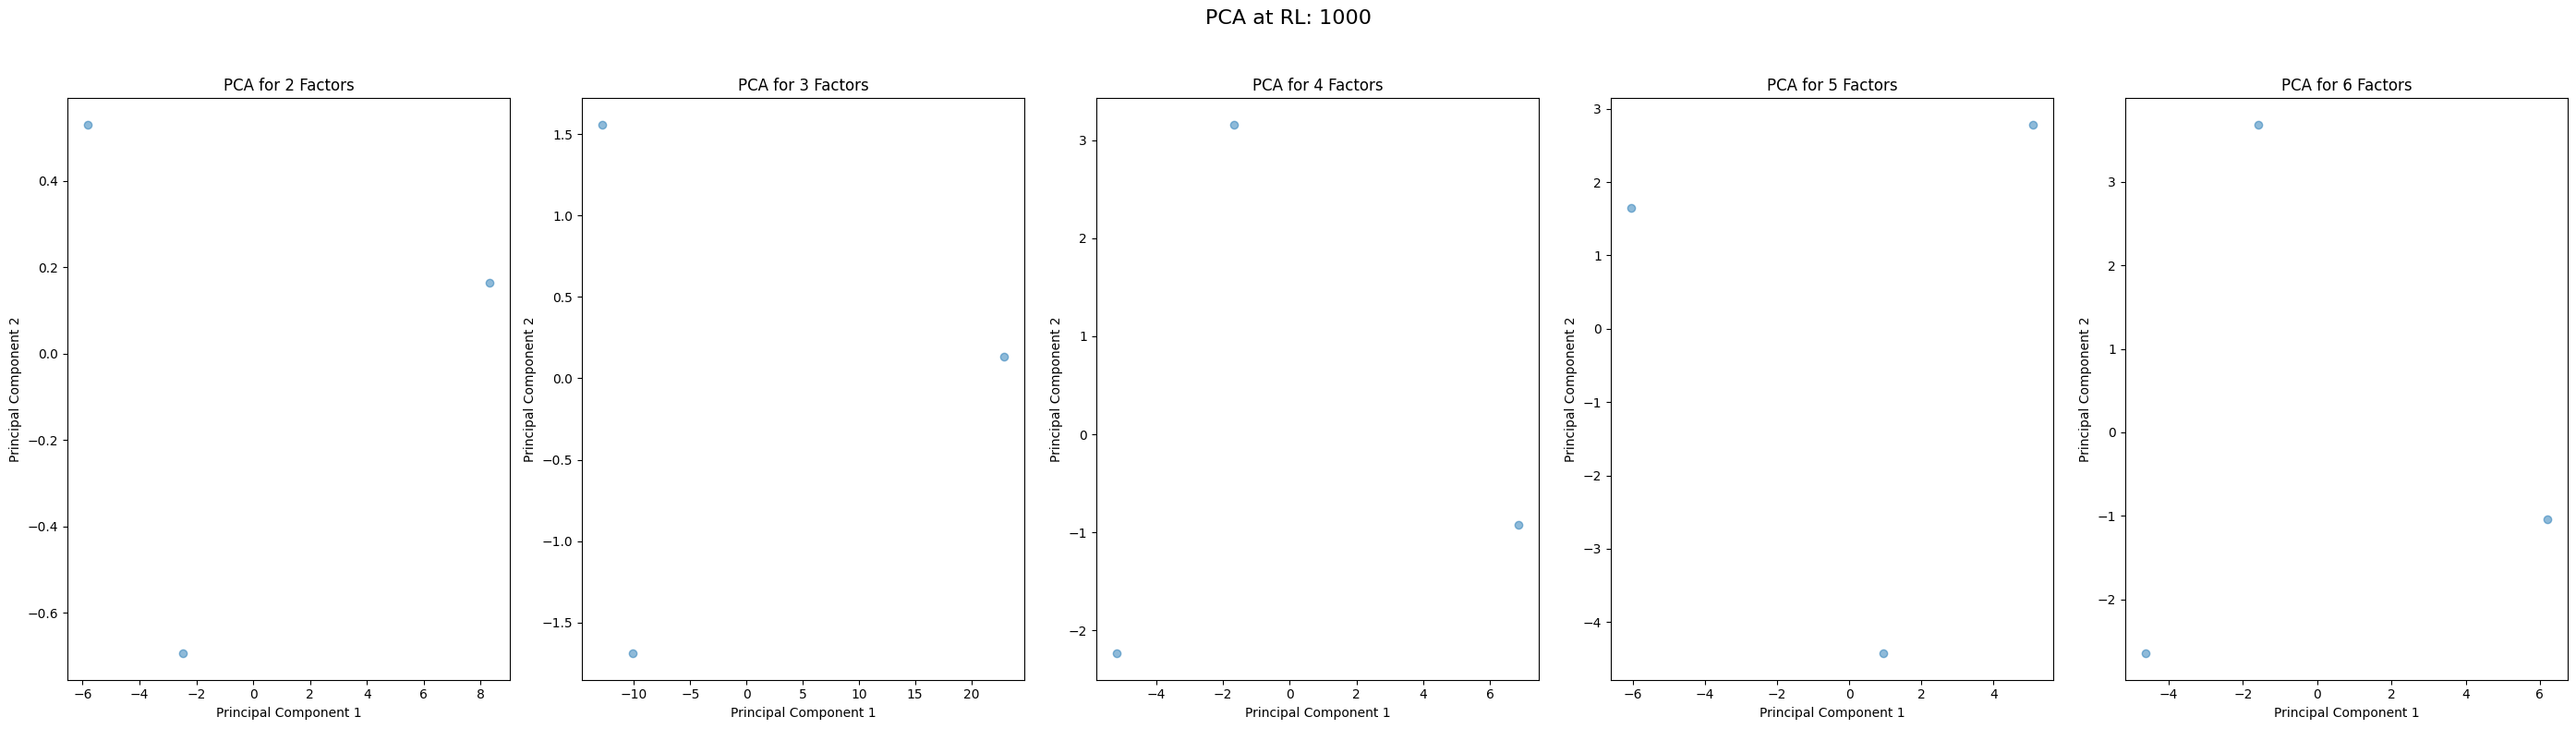

In [138]:
for replacement_level in REPLACEMENT_LEVELS:

    fig, axs = plt.subplots(nrows=1, ncols=len(LATENT_FACTORS[1:]), figsize=(28, 8))

    for i, num_factors in enumerate(LATENT_FACTORS[1:]):
        df = athletes[f'{replacement_level}_{num_factors}']

        axs[i].scatter(df['PC1'], df['PC2'], alpha=0.5)

        # for j, name in enumerate(df.index):
        #     if name == 'other':
        #         axs[i].text(df['PC1'][j], df['PC2'][j], name, color='red', fontsize=9)
        #     else:
        #         continue # Add labels?

        axs[i].set_title(f'PCA for {num_factors} Factors')
        axs[i].set_xlabel('Principal Component 1')
        axs[i].set_ylabel('Principal Component 2')

    plt.suptitle(f'PCA at RL: {replacement_level}', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])

    # plt.savefig(f'figs/PCA_{replacement_level}.png')
    # plt.close(fig)